<a href="https://colab.research.google.com/github/J-Pitts/J-Pitts.github.io/blob/master/TitanicML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns

from scipy.stats import mstats
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer


Read and Inspect Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

#Check variables

print(df.head())

print('Shape:', df.shape)

print(df.dtypes)



   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Sh

Determine Relevancy

In [ ]:
# Drop irrelevant
df = df.drop(columns=['Name', 'PassengerId','Ticket','SibSp','Parch'])

Check for missing data

In [ ]:
# Check for missing data easy
#for col in df.columns:
#  print('Column With Missing Values:', col, df[col].isna().sum())

# Check for missing data tabular
missing_count = df.isna().sum().tolist()
missing_percent = (df.isna().sum()/df.shape[0])*100
categories = ['Missing Count','Missing %']

missing_data = pd.DataFrame(data=[missing_count, missing_percent], 
           columns=df.columns, index=categories).transpose()

missing_data['Missing %'] = missing_data['Missing %'].map('{:,.2f}%'.format)
display(missing_data)

,Missing Count,Missing %
Survived,0.0,0.00%
Pclass,0.0,0.00%
Sex,0.0,0.00%
Age,177.0,19.87%
Fare,0.0,0.00%
Cabin,687.0,77.10%
Embarked,2.0,0.22%


Impute Data : Fill Missing Data

In [ ]:
#Fill missing ages
age_imputer = SimpleImputer(strategy='median')
df['Age'] = age_imputer.fit_transform(df['Age'].values.reshape(-1,1))


Remove Unusable Columns: The cabin variable is missing too many values for me to justify filling. Conceptually, cabin designation may relate to survival given scenarios such as proximity to emergency raft.

In [ ]:
df = df.drop('Cabin', axis=1)

Lets check the distribution of the remaining columns

         Survived      Pclass         Age        Fare    vote_age
count  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.361582   32.204208    0.873176
std      0.486592    0.836071   13.019697   49.693429    0.332962
min      0.000000    1.000000    0.420000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    7.910400    1.000000
50%      0.000000    3.000000   28.000000   14.454200    1.000000
75%      1.000000    3.000000   35.000000   31.000000    1.000000
max      1.000000    3.000000   80.000000  512.329200    1.000000


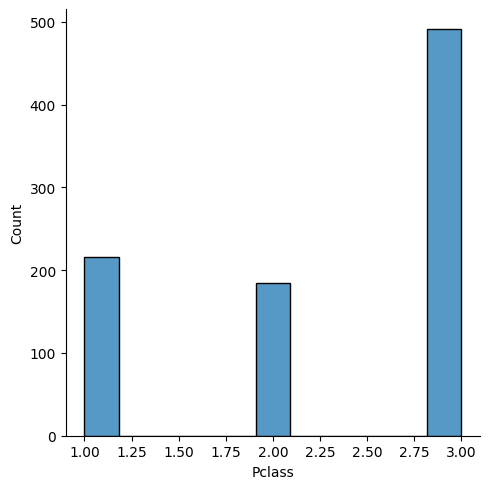

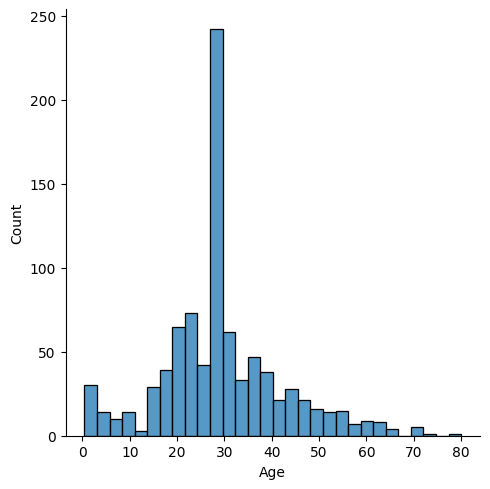

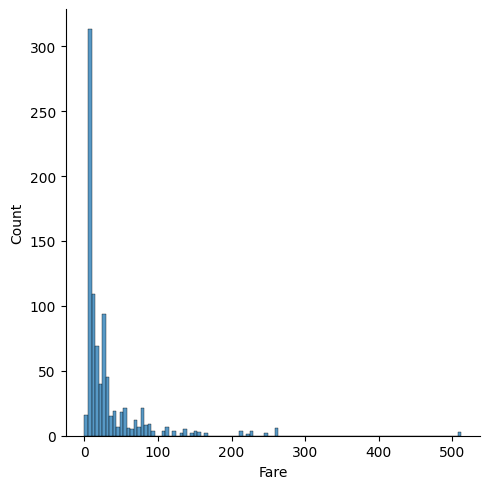

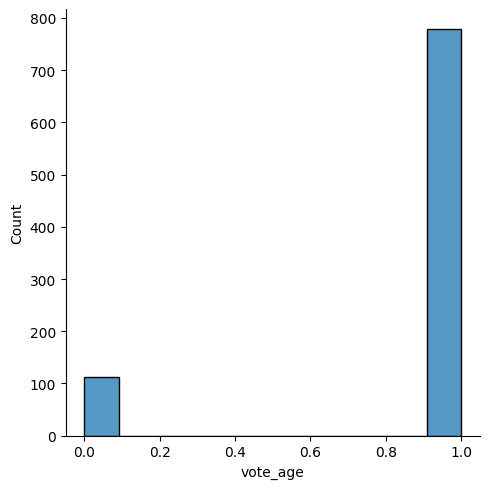

In [ ]:
print(df.describe())

# Check numerical columns, excluding dependent variable
for col in df.drop('Survived', axis=1).select_dtypes(exclude=['object']).columns:
  sns.displot(data=df.select_dtypes(exclude=['object']), x=col)


We have some skew issues, especially with Fare. Time to scale numerical values

Statistics - Zscore, descriptions etc.

Fare 512.3292 14.4542


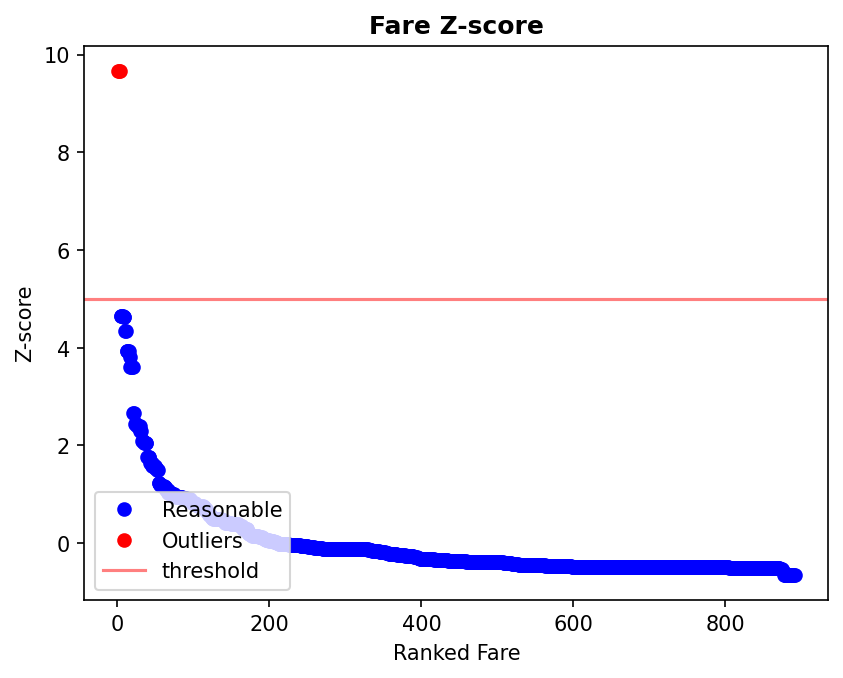

In [ ]:


def zscore(col):
  zscore_rate = ss.zscore(df[col], ddof=0)
  z_test = df.assign(zscore=zscore_rate)
  return df.assign(zscore=zscore_rate)



def plot_anomaly(score_data, threshold, col):
    
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='b',label='Reasonable')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='r', label='Outliers')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title((col+' Z-score'), fontweight='bold')
    plt.xlabel(('Ranked '+col))
    plt.ylabel('Z-score')
    plt.show()


df2 = df.drop('Survived', axis = 1)


for col in df2.select_dtypes(exclude=['object']).columns:
  #x = zscore(col)
  if np.max(df2[col]) > (3 * np.median(df2[col])):
    print(col, np.max(df2[col]),np.median(df2[col]))
    plot_anomaly(zscore(col)['zscore'], 5, col)
   #df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])

#df['Fare'] = mstats.winsorize(df['Fare'], limits=[0.05, 0.05])

#sns.displot(data=df['Fare'].values, x=df['Fare'])





In [ ]:
from sklearn.model_selection import train_test_split

# separate features and target
X = df.drop('Survived', axis=1)
y = df['Survived']
    
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [ ]:
# import libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier


# get the categorical and numeric column names
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# pipeline for numerical columns
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler()
)
# pipeline for categorical columns
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N/A'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

models = [DecisionTreeClassifier(),
          SVC(gamma='scale'),
          BaggingClassifier(n_estimators=100),
          RandomForestClassifier(n_estimators=100),
          GradientBoostingClassifier(n_estimators=100),
          LogisticRegression(max_iter=1000, random_state=42)]


#print(models)
# build the model
for model in models:
  i = make_pipeline(full_pipe, model)
  i.fit(X_train, y_train)
  print(model, accuracy_score(y_test,i.predict(X_test)))


DecisionTreeClassifier() 0.8097014925373134
SVC() 0.835820895522388
BaggingClassifier(n_estimators=100) 0.8395522388059702
RandomForestClassifier() 0.8395522388059702
GradientBoostingClassifier() 0.8619402985074627
LogisticRegression(max_iter=1000, random_state=42) 0.8171641791044776


Our best success was Gradient Boosting

In [ ]:
print()